<h1>Project </h1>
<hr>
<h1>Identify Localities in Pune,India which have maximum need for creation of new Hospitals</h1>
<hr>

<h1>Importing relevant libraries</h1>

In [4]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import folium
import requests 
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import json
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

<h1>Scrapping webpage to obtain names of all Localities in Pune</h1>

In [5]:
url="https://www.mapsofindia.com/pune/localities/"
page = requests.get(url).text
soup = BeautifulSoup(page, "lxml")
all_list=soup.find_all("a")
#print(soup.prettify())
#print(all_list)
flag=0
cnt=0
localities=[]
for li in all_list:
    #print(li.text)
    if(li.text.rstrip()=='Alandi Road'):
        flag=1
    if(flag==1):
        localities.append(li.text.rstrip())
    if(li.text=='Yerawada ' ):
        flag=0


<h1>Getting geographical coordinates for all Localities</h1>

In [6]:
latitudes=[]
longitudes=[]
for x in localities:
    geolocator=Nominatim(user_agent=x)
    location=geolocator.geocode(x+',Pune',timeout=50)
    #print(location)
    if(location!=None):
        
        lat=location.latitude
        lon=location.longitude
        latitudes.append(lat)
        longitudes.append(lon)
    else:
        latitudes.append("na")
        longitudes.append("na")


<h1>Preparing our Dataframe</h1>

In [7]:
df=pd.DataFrame([localities,latitudes,longitudes])
df=df.transpose()
df.columns=['Locality','Latitude','Longitude']
df=df[(df['Latitude']!='na') & (df['Longitude']!='na')]
df.reset_index(drop=True,inplace=True)
df

,Locality,Latitude,Longitude
0,Alandi Road,18.5523,73.8733
1,Ambegaon Budruk,18.4511,73.8376
2,Anandnagar,18.5083,73.8152
3,Aundh,18.5619,73.8102
4,Aundh Road,18.5619,73.8102
...,...,...,...
76,Viman Nagar,18.5214,73.8545
77,Wagholi,18.5806,73.9833
78,Wanowrie,18.4884,73.8987
79,Warje,18.482,73.8002


<h1>Lets Visualize our  localities before clustering</h1>

In [8]:
geolocator=Nominatim(user_agent='Pune')
location=geolocator.geocode('Pune,Maharashtra')
Pune=folium.Map(location=[location.latitude,location.longitude],zoom_start=11)
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Locality']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Pune)
Pune

<h1>Setting up Foursquare API</h1>
<hr>
<h1>Note: Using a file to store credentials for Security Reasons</h1>

In [10]:
credentials=pd.read_excel('4squarecredentials.xlsx')
CLIENT_ID = credentials.loc[0]['CLIENT_ID']
CLIENT_SECRET = credentials.loc[0]['CLIENT_SECRET']
VERSION = '202005015'
radius=3000

LIMIT=200

<h1>Lets create a function to fetch Hospitals in 3km radius of our Localities </h1>
<hr>
<h1>The categoryId for hospitals has been added to the URL</h1>

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId=4bf58dd8d48988d196941735&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h1>Lets call our function and get relevant data</h1>

In [12]:
Finaldf = getNearbyVenues(names=df['Locality'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )
Finaldf


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alandi Road,18.552349,73.873259,Ruby Hall Clinic,18.533768,73.876809,Hospital
1,Alandi Road,18.552349,73.873259,Serene Hospital,18.572227,73.879019,Hospital
2,Alandi Road,18.552349,73.873259,Inlaks & Budhrani Hospital,18.535327,73.887502,Hospital
3,Alandi Road,18.552349,73.873259,Jehangir Hospital,18.530495,73.876567,Hospital
4,Alandi Road,18.552349,73.873259,Sahaydri Hospital,18.554218,73.897066,Hospital
...,...,...,...,...,...,...,...
667,Warje,18.482044,73.800170,Deoyani hospital,18.494410,73.812720,Hospital
668,Warje,18.482044,73.800170,Shashwat hospital,18.495182,73.813535,Hospital
669,Warje,18.482044,73.800170,Sahyadri Hospital,18.507457,73.805752,Hospital
670,Yerawada,18.565632,73.886576,Serene Hospital,18.572227,73.879019,Hospital


<h1>Lets extract our feature ie The number of hospitals and add it to our dataframe</h1>

In [13]:
Finaldf.rename(columns={'Neighborhood':'Locality','Neighborhood Latitude':'Locality Latitude','Neighborhood Longitude':'Locality Longitude'},inplace=True)
Analysisdf=Finaldf.groupby(['Locality','Locality Latitude','Locality Longitude']).count()
Analysisdf.reset_index(inplace=True)
Analysisdf=Analysisdf.iloc[:,:4]
Analysisdf.rename(columns={'Venue':'Hospital Count'},inplace=True)
Analysisdf

,Locality,Locality Latitude,Locality Longitude,Hospital Count
0,Alandi Road,18.552349,73.873259,6
1,Ambegaon Budruk,18.451118,73.837555,3
2,Anandnagar,18.508338,73.815208,10
3,Aundh,18.561883,73.810196,8
4,Aundh Road,18.561883,73.810196,8
...,...,...,...,...
74,Wadgaon Sheri,18.550441,73.917167,4
75,Wagholi,18.580630,73.983310,3
76,Wanowrie,18.488368,73.898667,6
77,Warje,18.482044,73.800170,4


<h1>Lets find out the optimal number of clusters using Elbow method and Calinski-Harabasz Index</h1>

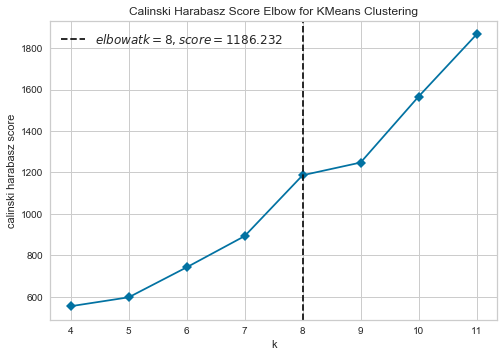

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
# set number of clusters
#for kclusters in range(2,20):
 #   kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Analysisdf[['Hospital Count']])
  #  print(kclusters,silhouette_score(Analysisdf[['Hospital Count']],kmeans.labels_))
model=KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False,locate_elbow=True
)

visualizer.fit(Analysisdf[['Hospital Count']])        # Fit the data to the visualizer
visualizer.show()   
# run k-means clustering


# check cluster labels generated for each row in the dataframe and also the cluster centroids
#print(kmeans.labels_,kmeans.cluster_centers_)

<h1>Clustering the localities into 8 clusters </h1>

In [15]:
kclusters=8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Analysisdf[['Hospital Count']])
print(kmeans.labels_,kmeans.cluster_centers_)

[5 0 7 2 2 3 5 0 7 6 0 1 2 7 0 4 1 4 0 5 2 1 1 2 1 5 3 5 6 0 2 0 0 5 3 1 0
 4 0 5 5 5 0 1 4 3 1 6 3 5 0 6 6 1 0 5 0 4 6 6 3 6 2 0 6 6 5 1 0 7 7 3 4 6
 0 0 5 0 4] [[ 3.57894737]
 [14.9       ]
 [ 7.57142857]
 [12.57142857]
 [ 1.42857143]
 [ 5.53846154]
 [16.54545455]
 [10.        ]]


<h1>Adding cluster labels to our DataFrame</h1>
<hr>

In [16]:
Analysisdf.insert(0,'Cluster Labels', kmeans.labels_)
Analysisdf

,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
0,5,Alandi Road,18.552349,73.873259,6
1,0,Ambegaon Budruk,18.451118,73.837555,3
2,7,Anandnagar,18.508338,73.815208,10
3,2,Aundh,18.561883,73.810196,8
4,2,Aundh Road,18.561883,73.810196,8
...,...,...,...,...,...
74,0,Wadgaon Sheri,18.550441,73.917167,4
75,0,Wagholi,18.580630,73.983310,3
76,5,Wanowrie,18.488368,73.898667,6
77,0,Warje,18.482044,73.800170,4


<h1>Lets Visualize our Clusters</h1>

In [18]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[location.latitude,location.longitude],zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Analysisdf['Locality Latitude'], Analysisdf['Locality Longitude'], Analysisdf['Locality'], Analysisdf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1>Cluster-0</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-0 and finding the average number of hospitals in this cluster</h1>
<hr>

In [19]:
Cluster0=Analysisdf[Analysisdf['Cluster Labels']==0]
Cluster0averageHospitalCount=Cluster0['Hospital Count'].mean()
print('The average Hospital count of Cluster0 is',Cluster0averageHospitalCount)
Cluster0

The average Hospital count of Cluster0 is 3.5789473684210527


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
1,0,Ambegaon Budruk,18.451118,73.837555,3
7,0,Baner road,18.564642,73.775079,4
10,0,Bibvewadi,18.478174,73.862105,3
14,0,Chandan Nagar,19.121709,72.923203,4
18,0,Dhayari Phata,18.460862,73.812755,3
29,0,Hadapsar,18.526967,73.927825,4
31,0,Hingne Khurd,18.479670,73.825099,3
32,0,Kalyani Nagar,18.548138,73.902551,4
36,0,Katraj,18.453679,73.856320,4
38,0,Kharadi,18.550518,73.942494,4


<h1>Cluster-1</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-1 and finding the average number of hospitals in this cluster</h1>
<hr>

In [20]:
Cluster1=Analysisdf[Analysisdf['Cluster Labels']==1]
Cluster1averageHospitalCount=Cluster1['Hospital Count'].mean()
print('The average Hospital count of Cluster1 is',Cluster1averageHospitalCount)
Cluster1

The average Hospital count of Cluster1 is 14.9


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
11,1,Budhwar Peth,18.517560,73.858037,15
16,1,Deccan Gymkhana,18.515893,73.841160,15
21,1,Fergusson College Road,18.524149,73.838591,14
22,1,Ganesh Peth,18.515422,73.864737,15
24,1,Ghorpade Peth,18.524614,73.858885,15
35,1,Kasba Peth,18.521905,73.858290,15
43,1,Law College Road,18.519653,73.830352,15
46,1,Mangalwar peth,18.524339,73.859208,15
53,1,Navi Peth,18.509270,73.844150,15
67,1,Shukrawar Peth,18.511354,73.854011,15


<h1>Cluster-2</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-2 and finding the average number of hospitals in this cluster</h1>
<hr>

In [21]:
Cluster2=Analysisdf[Analysisdf['Cluster Labels']==2]
Cluster2averageHospitalCount=Cluster2['Hospital Count'].mean()
print('The average Hospital count of Cluster2 is',Cluster2averageHospitalCount)
Cluster2

The average Hospital count of Cluster2 is 7.571428571428571


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
3,2,Aundh,18.561883,73.810196,8
4,2,Aundh Road,18.561883,73.810196,8
12,2,Bund Garden Road,18.530755,73.875670,8
20,2,Fatima Nagar,18.504510,73.902129,7
23,2,Ganeshkhind,18.553160,73.825296,8
30,2,Hadapsar Industrial Estate,18.509894,73.915961,7
62,2,Sahakar Nagar,18.490080,73.847530,7


<h1>Cluster3</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-3 and finding the average number of hospitals in this cluster</h1>
<hr>

In [22]:
Cluster3=Analysisdf[Analysisdf['Cluster Labels']==3]
Cluster3averageHospitalCount=Cluster3['Hospital Count'].mean()
print('The average Hospital count of Cluster3 is',Cluster3averageHospitalCount)
Cluster3

The average Hospital count of Cluster3 is 12.571428571428571


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
5,3,Balaji Nagar,19.061083,72.900459,12
26,3,Gokhale Nagar,18.534726,73.829581,13
34,3,Karve Road,18.507725,73.829400,13
45,3,Mahatma Gandhi Road,19.205666,72.843302,12
48,3,Model colony,18.531430,73.837451,13
60,3,Rasta Peth,18.521915,73.866576,12
71,3,Tilak Road,19.082320,72.839462,13


<h1>Cluster-4</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-4 and finding the average number of hospitals in this cluster</h1>
<hr>

In [23]:
Cluster4=Analysisdf[Analysisdf['Cluster Labels']==4]
Cluster4averageHospitalCount=Cluster4['Hospital Count'].mean()
print('The average Hospital count of Cluster4 is',Cluster4averageHospitalCount)
Cluster4

The average Hospital count of Cluster4 is 1.4285714285714286


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
15,4,Dapodi,18.580846,73.832775,1
17,4,Dehu Road,18.680047,73.734331,1
37,4,Khadki,18.568175,73.850779,2
44,4,Laxmi Road,18.141836,74.561703,2
57,4,Pirangut,18.511282,73.679007,1
72,4,Vadgaon Budruk,18.467497,73.825365,1
78,4,Yerawada,18.565632,73.886576,2


<h1>Cluster-5</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-5 and finding the average number of hospitals in this cluster</h1>
<hr>

In [24]:
Cluster5=Analysisdf[Analysisdf['Cluster Labels']==5]
Cluster5averageHospitalCount=Cluster5['Hospital Count'].mean()
print('The average Hospital count of Cluster5 is',Cluster5averageHospitalCount)
Cluster5

The average Hospital count of Cluster5 is 5.538461538461538


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
0,5,Alandi Road,18.552349,73.873259,6
6,5,Baner,18.564243,73.776857,5
19,5,Dhole Patil Road,18.534908,73.876258,6
25,5,Ghorpadi,18.526854,73.900096,6
27,5,Gultekdi,18.493894,73.867633,5
33,5,Karve Nagar,18.489404,73.821324,6
39,5,Kondhwa,18.477746,73.894138,5
40,5,Kondhwa Budruk,18.477746,73.894138,5
41,5,Koregaon Park,18.537553,73.893925,6
49,5,Mukund Nagar,18.494597,73.859923,5


<h1>Cluster-6</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-6 and finding the average number of hospitals in this cluster</h1>
<hr>

In [25]:
Cluster6=Analysisdf[Analysisdf['Cluster Labels']==6]
Cluster6averageHospitalCount=Cluster6['Hospital Count'].mean()
print('The average Hospital count of Cluster6 is',Cluster6averageHospitalCount)
Cluster6

The average Hospital count of Cluster6 is 16.545454545454547


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
9,6,Bhavani Peth,18.521428,73.854454,17
28,6,Guruwar peth,18.511359,73.857620,16
47,6,Market yard,18.521428,73.854454,17
51,6,Nana Peth,18.518357,73.856310,17
52,6,Narayan Peth,18.515579,73.851077,16
58,6,Prabhat Road,18.511931,73.831611,16
59,6,Pune Railway Station,18.521428,73.854454,17
61,6,Sadashiv Peth,18.510776,73.850215,16
64,6,Senapati Bapat Road,18.990324,72.823337,16
65,6,Shaniwar Peth,18.519284,73.852486,17


<h1>Cluster-7</h1>
<hr>
<h1>Filtering Localities belonging to Cluster-7 and finding the average number of hospitals in this cluster</h1>
<hr>

In [26]:
Cluster7=Analysisdf[Analysisdf['Cluster Labels']==7]
Cluster7averageHospitalCount=Cluster7['Hospital Count'].mean()
print('The average Hospital count of Cluster7 is',Cluster7averageHospitalCount)
Cluster7

The average Hospital count of Cluster7 is 10.0


,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
2,7,Anandnagar,18.508338,73.815208,10
8,7,Bhandarkar Road,19.027714,72.852903,11
13,7,Camp,19.073828,72.825175,10
69,7,Somwar Peth,18.528877,73.874415,9
70,7,Swargate,18.500728,73.858377,10


<h1>Sorting clusters based on average number of hospitals</h1>

In [27]:
centroids=pd.DataFrame(kmeans.cluster_centers_,columns=['mean_hospitals'])
centroids.sort_values(by='mean_hospitals',inplace=True)
centroids.reset_index(inplace=True)
centroids.rename(columns={'index':'Cluster_number'},inplace=True)
centroids

,Cluster_number,mean_hospitals
0,4,1.428571
1,0,3.578947
2,5,5.538462
3,2,7.571429
4,7,10.000000
5,3,12.571429
6,1,14.900000
7,6,16.545455


<h1>Visulaizing clusters with their mean hospital values<h1>

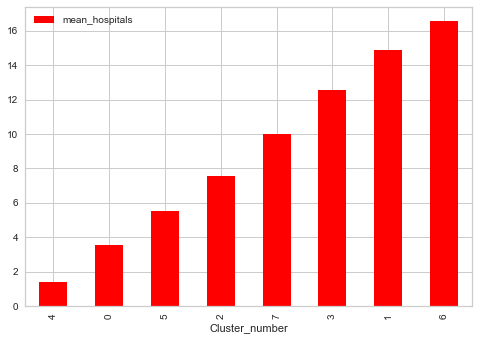

In [41]:
centroids.plot(kind='bar',x='Cluster_number',y='mean_hospitals',color='red')

<h1>CONCLUSION</h1>
<hr>
<h1>Cluster-4 has the lowest "Mean Number of Hospitals" ie 1.42 hospitals</h1>
<hr>
<h1>Cluster-0 has the second lowest "Mean Number of Hospitals" ie 3.57 hospitals</h1>
<hr>
<h1>Thus new hospitals should be built with the highest priority in the localities belonging to cluster-4 followed by Cluster-0</h1>

In [91]:
Cluster4

,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
15,4,Dapodi,18.580846,73.832775,1
17,4,Dehu Road,18.680047,73.734331,1
37,4,Khadki,18.568175,73.850779,2
44,4,Laxmi Road,18.141836,74.561703,2
57,4,Pirangut,18.511282,73.679007,1
72,4,Vadgaon Budruk,18.467497,73.825365,1
78,4,Yerawada,18.565632,73.886576,2


In [92]:
Cluster0

,Cluster Labels,Locality,Locality Latitude,Locality Longitude,Hospital Count
1,0,Ambegaon Budruk,18.451118,73.837555,3
7,0,Baner road,18.564642,73.775079,4
10,0,Bibvewadi,18.478174,73.862105,3
14,0,Chandan Nagar,19.121709,72.923203,4
18,0,Dhayari Phata,18.460862,73.812755,3
29,0,Hadapsar,18.526967,73.927825,4
31,0,Hingne Khurd,18.479670,73.825099,3
32,0,Kalyani Nagar,18.548138,73.902551,4
36,0,Katraj,18.453679,73.856320,4
38,0,Kharadi,18.550518,73.942494,4
